In [3]:
# i have used different deep learning models with different embedding of words 

In [4]:
import numpy as np
import pandas as pd

In [5]:
import sys, os, re, csv, codecs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Conv1D, concatenate, Flatten, Concatenate
from tensorflow.keras.layers import  BatchNormalization, Dropout, Activation, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [6]:
!pip install scikit-learn
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 6.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [7]:
multi_train = pd.read_csv('train.csv')

multi_validation = pd.read_csv('dev.csv')

multi_test = pd.read_csv('test.csv')

In [8]:
# change the column names
multi_train.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"}, inplace=True)
multi_validation.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)
multi_test.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)

In [9]:
multi_train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [10]:
# Drop Duplicates

# keep the first occurance of duplicates for all three datasets and drop the rest

multi_train.drop_duplicates(keep = 'first', inplace=True)
multi_validation.drop_duplicates(keep = 'first', inplace=True)
multi_test.drop_duplicates(keep = 'first', inplace=True)

In [11]:
train = pd.concat([multi_train, multi_validation], axis=0 ) # concat train and validation set 
train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [12]:
test = multi_test  # test set

In [13]:
train.shape, test.shape

((7735, 4), (1640, 4))

In [14]:
y_train = train[['Commenting', 'Staring', 'Touching']].values
y_test = test[['Commenting', 'Staring', 'Touching']].values

## Tokenization and Padding

In [15]:
# Text Data 
description_train_text =list(train['Description'].values)
description_test_text = list(test['Description'].values)

# tokenize the Text data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit on train data
tokenizer.fit_on_texts(description_train_text)     
# transform train and test data
train_description_sequences = tokenizer.texts_to_sequences(description_train_text)
test_description_sequences = tokenizer.texts_to_sequences(description_test_text)

# vocabulary size 
vocab_size = len(tokenizer.word_index) + 1

# pad the sequnce

train_description_padded = pad_sequences(
        train_description_sequences, maxlen=300, dtype='int32', padding='post',  
        truncating='post')                                                  

test_description_padded = pad_sequences(
        test_description_sequences, maxlen=300, dtype='int32', padding='post', 
        truncating='post')                                  

### performance metrics 

In [16]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 4.0 MB/s eta 0:00:0000:0100:01
  Using cached packaging-23.2-py3-none-any.whl (53 kB)

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [57]:
import tensorflow as tf

# Define functions to compute F1 Score and Hamming Loss
def f1_score(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.greater(y_pred, threshold), tf.float32)
    true_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32), axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    actual_positives = tf.reduce_sum(y_true, axis=0)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

def hamming_loss(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(tf.math.greater(y_pred, threshold), tf.float32)
    hamming_loss = 1 - tf.reduce_mean(tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32), axis=1))
    return hamming_loss

# Assuming y_test and y_pred are defined
# Compute F1 Score and Hamming Loss
f1_score_value = f1_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

# Print the results
print('F1 Score:', f1_score_value.numpy())
print('Hamming Loss:', hamming_loss_value.numpy())
print('hamming score:',1-hamming_loss_value.numpy())

F1 Score: 0.6621101
Hamming Loss: 0.16626018
hamming score: 0.8337398171424866


In [18]:
# Exact match ratio
def exact_match_ratio(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

In [19]:
# conver probabilities to labels

def prob_to_class(arr):   # converts probailities to class labes based on 0.5 threshold
    r,c = arr.shape
    predict =np.zeros((r, c))
    for i in range(r):
        for j in range(c):
            if arr[i,j]>0.5:
                predict[i,j] = 1
    return predict

# FastText Embeddings

In [24]:
!pip install --upgrade pip
!pip install gensim
!pip install matplotlib
from gensim.models.fasttext import FastText
%matplotlib inline 

In [26]:
import nltk

In [27]:
embedding_size = 300  #  size of the embedding vector. 
window_size = 20    # size of the number of words occurring before and after the word based on which the word representations.
min_word = 5  # minimum frequency of a word in the corpus for which the word representations will be generated
down_sampling = 1e-2   # most frequently occurring word will be down-sampled by a number specified by the down_sampling 

In [28]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in description_train_text]

In [29]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=100)

CPU times: user 8min 10s, sys: 1.58 s, total: 8min 11s
Wall time: 2min 47s


In [30]:
embedding_matrix_fast_text = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ft_model.wv[word] # getting the vector for each word
  except:
    embedding_vector = np.zeros(300)
  
  if embedding_vector is not None:
    embedding_matrix_fast_text[i] = embedding_vector

## Bidirectional LSTM + Conv1D layer with FastText Embedding 

In [51]:
inputs = Input(shape=(max_input,))  # input 
embedding = Embedding(vocab_size, embedding_size, trainable=False) 

embedding.build((None,))
embedding.set_weights([embedding_matrix])
embeddings = embedding(inputs)

x = SpatialDropout1D(0.35)(embeddings)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)  

x = concatenate([avg_pool, max_pool])

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)   

outputs = Dense(3, activation='sigmoid')(x)  # output

model_4_fast_text = Model(inputs=inputs, outputs = outputs)  # model

In [52]:
model_4_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_4_fast_text.fit(train_description_padded, y_train, batch_size=64, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 55s 441ms/step - binary_accuracy: 0.6715 - loss: 0.6147 - val_binary_accuracy: 0.8102 - val_loss: 0.5258
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 427ms/step - binary_accuracy: 0.8073 - loss: 0.4556 - val_binary_accuracy: 0.8299 - val_loss: 0.4275
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 428ms/step - binary_accuracy: 0.8304 - loss: 0.4171 - val_binary_accuracy: 0.8341 - val_loss: 0.3948
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 423ms/step - binary_accuracy: 0.8424 - loss: 0.3944 - val_binary_accuracy: 0.8390 - val_loss: 0.3917
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 423ms/step - binary_accuracy: 0.8529 - loss: 0.3682 - val_binary_accuracy: 0.8378 - val_loss: 0.3977
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 422ms/step - binary_accuracy: 0.8570 - loss: 0.3601 - val_binary_accuracy: 0.8368 - val_loss: 0.3981
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 424ms/step - binary_accuracy: 0.8592 - loss: 0.3479 - val_binary_accuracy: 0.8388 - va

In [53]:
score = model_4_fast_text.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - binary_accuracy: 0.8281 - loss: 0.4642
Loss: 0.43027713894844055
Accuracy: 0.833739697933197


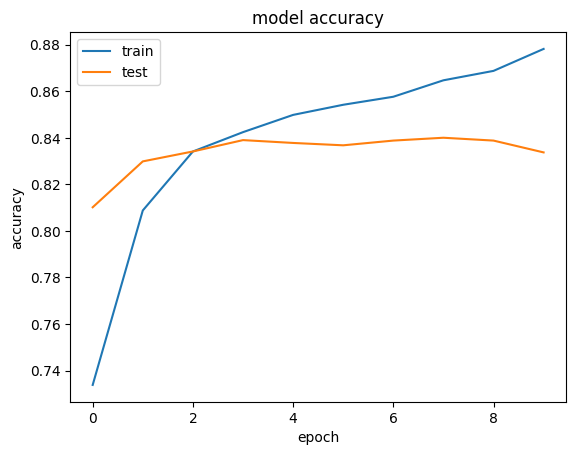

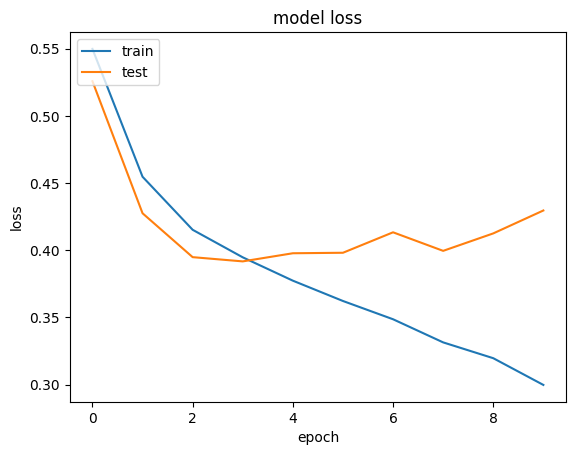

In [54]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [55]:
y_pred = model_4_fast_text.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step


In [56]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, threshold=0.5))

Hamming Loss:  tf.Tensor(0.16626018, shape=(), dtype=float32)
Exact Match Ratio:  0.6189024390243902
Recall:  0.6398390342052314
Precision:  0.7724696356275303
Fl score:  tf.Tensor(0.6621101, shape=(), dtype=float32)


In [37]:
# model_4_fast_text.save('model_4_fast_text.h5')
# model_2 = tf.keras.models.load_model('cnn_model.h5') #same file path